#ArabicSignLanguage
In this notebook I'll apply:

**1 - Custom Dataset Class to to handle the dataset files and divided data into batches with size 64**

**2 - Build a Classification model to classify arabic letters from the images given to the model**

**3 - Build an autoencoder that reconstruct the image from only 1152 pixels with PSNR as metric and reached 27Db which is visible but not that much**


##1 - Build Dataset class & batch the data

In [ ]:
# importing libraries
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm
import time
from torchsummary import summary

In [ ]:
!gdown https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded

Downloading...
From: https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded
To: /content/file_downloaded
100% 66.2M/66.2M [00:03<00:00, 18.0MB/s]


In [ ]:
!unzip file_downloaded
clear_output()

In [ ]:
def rename_folders_and_create_mapping(folder_path):
    # Get the list of folders in the specified path
    folders = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    # Create a mapping from original folder names to numbers
    folder_mapping = {folder: i for i, folder in enumerate(folders)}

    # Rename the folders in-place and store the original names in the mapping
    for original_folder, number in folder_mapping.items():
        new_folder_name = str(number)
        new_folder_path = os.path.join(folder_path, new_folder_name)

        # Rename the folder
        os.rename(os.path.join(folder_path, original_folder), new_folder_path)

    return folder_mapping

folder_path = 'ArASL_Database_54K_Final'

# Create the folder mapping and rename folders
mapping = rename_folders_and_create_mapping(folder_path)

# Print the folder mapping
print("Folder Mapping:")
print(mapping)

Folder Mapping:
{'thaa': 0, 'haa': 1, 'gaaf': 2, 'laam': 3, 'bb': 4, 'meem': 5, 'ya': 6, 'la': 7, 'kaaf': 8, 'ghain': 9, 'waw': 10, 'nun': 11, 'aleff': 12, 'yaa': 13, 'jeem': 14, 'dhad': 15, 'dha': 16, 'toot': 17, 'sheen': 18, 'seen': 19, 'khaa': 20, 'zay': 21, 'ta': 22, 'saad': 23, 'dal': 24, 'thal': 25, 'al': 26, 'taa': 27, 'ra': 28, 'fa': 29, 'ain': 30, 'ha': 31}


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None, target_size=(28, 28)):
        self.root_folder = root_folder
        self.transform = transform
        self.target_size = target_size

        # Get the list of image files
        self.image_files = []
        self.image_labels = []

        for root, dirs, files in os.walk(root_folder):
            for file in files:
                if file.lower().endswith('.jpg'):
                    self.image_files.append(os.path.join(root, file))
                    self.image_labels.append(int(os.path.basename(root)))

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.image_labels[idx]

        # Convert label to tensor
        # print("Label", label, type(label))
        label = torch.tensor(label)
        # Open the image
        with Image.open(img_path) as img:
            # Convert the image to grayscale
            img = img.convert('L')

            # Resize the image
            img = img.resize(self.target_size)

            # Apply additional transformations if specified
            if self.transform:
                img = self.transform(img)

            return (img, label)

# Define the root folder and output folder
root_folder_path = 'ArASL_Database_54K_Final'


# Define transformations (resize to 28x28 and convert to tensor)
data_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
custom_dataset = CustomDataset(root_folder_path, transform=data_transform)

from torch.utils.data import random_split

# Define the size of the training and validation sets
total_size = len(custom_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation
# Split the dataset
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

mapping = {v:k for k,v in mapping.items()}

In [ ]:
print("The mapping between the letters and the encoding: \n", mapping)
print('Length of train_dataset is', len(train_dataset))
print('Length of val_dataset is'  , len(val_dataset))

The mapping between the letters and the encoding: 
 {0: 'thaa', 1: 'haa', 2: 'gaaf', 3: 'laam', 4: 'bb', 5: 'meem', 6: 'ya', 7: 'la', 8: 'kaaf', 9: 'ghain', 10: 'waw', 11: 'nun', 12: 'aleff', 13: 'yaa', 14: 'jeem', 15: 'dhad', 16: 'dha', 17: 'toot', 18: 'sheen', 19: 'seen', 20: 'khaa', 21: 'zay', 22: 'ta', 23: 'saad', 24: 'dal', 25: 'thal', 26: 'al', 27: 'taa', 28: 'ra', 29: 'fa', 30: 'ain', 31: 'ha'}
Length of train_dataset is 43239
Length of val_dataset is 10810


In [ ]:
batch_size = 64

# DataLoaders simplify the job of grouping the samples into batches.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data

In [ ]:
train_dataset[0][0].shape

torch.Size([1, 48, 48])

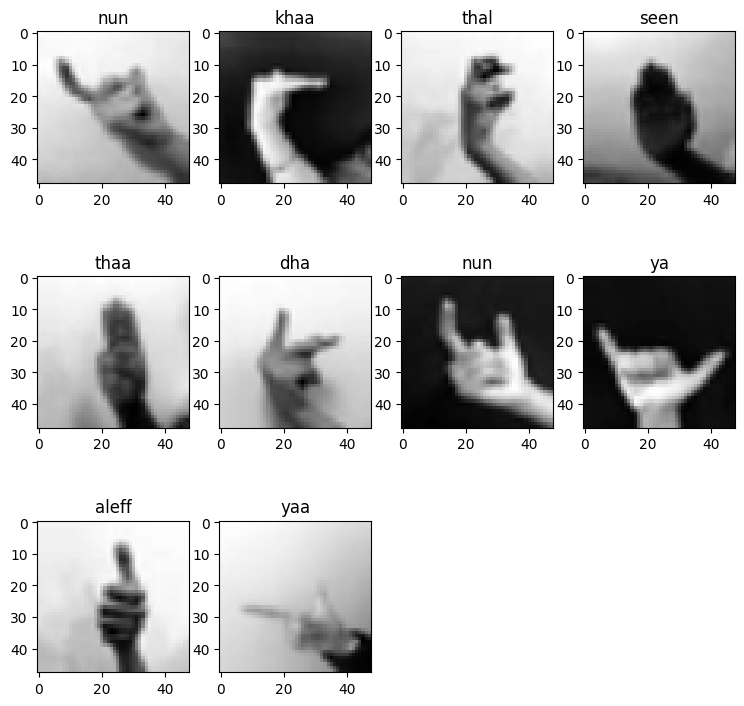

In [ ]:
# create figure
fig = plt.figure(figsize=(9, 9))

for i in range(10):
    random_img_idx = random.randint(0, 43238) # Write any random index (between 0 and 43238)

    image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
    label = train_dataset[random_img_idx][1]  # 1 for label part

    # Adds a subplot at the 2nd position
    fig.add_subplot(3, 4, i+1)
    plt.title(mapping[label.item()])
    plt.imshow(image.reshape(48, 48), cmap='gray')

##2 - Classification Model Training

In [ ]:
class CustomSignModel(nn.Module):
  def __init__(self):
    super(CustomSignModel, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3)
    self.pool = nn.MaxPool2d(3, 2)
    self.conv2 = nn.Conv2d(16, 32, 3, padding='same')
    self.conv3 = nn.Conv2d(32, 64, 3, padding='same')
    self.conv4 = nn.Conv2d(64, 64, 3, padding='same')
    self.conv5 = nn.Conv2d(64, 128, 3, padding='same')
    self.relu = nn.ReLU()
    self.conv6 = nn.Conv2d(128, 256, 3, padding='same')
    self.conv7 = nn.Conv2d(256, 256, 3, padding='same')
    self.fc1 = nn.Linear(256, 512)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 32)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    # Convolution + Pooling (Stage 1)
    x1 = self.pool(self.relu(self.conv1(x)))  # Conv1 + ReLU + MaxPool
    x2 = self.pool(self.relu(self.conv2(x1)))  # Conv2 + ReLU + MaxPool

    # Convolution + Pooling (Stage 2)
    x3 = self.relu(self.conv3(x2))  # Conv3 + ReLU
    x4 = self.relu(self.conv4(x3))  # Conv4 + ReLU
    x5 = self.relu(self.conv5(x4))  # Conv5 + ReLU
    x6 = self.pool(x5)  # MaxPool
    x7 = self.relu(self.conv6(x6))
    x8 = self.pool(self.relu(self.conv7(x7)))
    # Flatten and Fully Connected (Stage 3)
    x9 = x8.view(x.size(0), -1)  # Flatten
    x10 = self.relu(self.fc1(x9))  # FC1 + ReLU
    x11 = self.relu(self.fc2(x10))  # FC2 + ReLU
    x12 = self.softmax(self.fc3(x11))  # FC3 + Softmax
    return x12

In [ ]:
def train_model(model, optimizer, loss_fn, train_loader, val_loader = None, device = 'cpu', epochs = 5, use_tqdm = False):
  """
    Trains a given machine learning model on a dataset for a specified number of epochs.

    Parameters:
    ----------
    model : torch.nn.Module
        The neural network model to be trained.

    optimizer : torch.optim.Optimizer
        The optimization algorithm used to adjust the model's weights.

    loss_fn : callable
        The loss function to measure the error between predictions and actual labels.

    train_loader : torch.utils.data.DataLoader
        DataLoader providing batches of training data and corresponding labels.

    val_loader : torch.utils.data.DataLoader, optional (default=None)
        DataLoader providing batches of validation data. If provided, the function
        will evaluate the model after each epoch on this dataset.

    device : string, optional (default='cpu')
        The device on which the training will be executed (e.g., "cpu" or "cuda").

    epochs : int optional (default=5)
        The number of complete passes through the training dataset.

    use_tqdm : bool, optional (default=False)
        Function will show you the progress of the one epoch

    Returns:
    -------
    tuple (list, list, list) or (list):
        - If `val_loader` is provided, returns lists of training losses, validation losses, and accuracies.
        - Otherwise, returns only a list of training losses.

    Notes:
    -----
    - The loss values for both training and validation are computed as weighted
      averages across batches, normalized by dataset size.
    """
  device = torch.device(device)
  model.to(device)
  # just two lists of losses to track losses
  train_losses = []
  val_losses = []
  accuracy_scores = []
  for epoch in range(epochs):
    train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") if use_tqdm else train_loader
    model.train()
    train_epoch_weighted_loss = 0
    for batch_x, batch_y in train_loader_iter:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)
      optimizer.zero_grad() # Set the gradients to zero again to make another backprop
      y_pred = model(batch_x) # The model forwarding
      loss = criterion(y_pred, batch_y)
      loss.backward()
      optimizer.step() # will update the parameters of the model

      train_epoch_weighted_loss += (len(batch_y)*loss.item())
    train_epoch_loss = train_epoch_weighted_loss/len(train_loader.dataset)
    train_losses.append(train_epoch_loss)
    if val_loader is not None:
      model.eval()
      correct = 0
      with torch.no_grad(): # making sure to not update the parameters of the model

        val_epoch_weighted_loss = 0
        for batch_x, batch_y in val_loader:
          batch_x, batch_y = batch_x.to(device), batch_y.to(device)
          y_pred = model(batch_x)
          loss = criterion(y_pred, batch_y)
          val_epoch_weighted_loss += (len(batch_y)*loss.item())
          val_batch_y_pred = y_pred.argmax(dim=1) # returning the index of the maximum value in the array
          correct += (val_batch_y_pred == batch_y).sum().item() # counting the correct predictions
        val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        accuracy = correct / len(val_loader.dataset) * 100  # Convert to percentage
        accuracy_scores.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs} -- Train Loss: {train_epoch_loss:.6f} -- Val Loss: {val_epoch_loss:.6f} -- Accuracy: {accuracy:.6f}%")
    else:
      print(f"Epoch {epoch+1}/{epochs} -- Train Loss: {train_epoch_loss:.6f}")
  print(f'Training complete on device {device}.')
  if val_loader is not None:
    return train_losses, val_losses, accuracy_scores
  else:
    return train_losses

In [ ]:
model = CustomSignModel()

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [ ]:
epochs = 10

In [ ]:
summary(model, (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 46, 46]             160
              ReLU-2           [-1, 16, 46, 46]               0
         MaxPool2d-3           [-1, 16, 22, 22]               0
            Conv2d-4           [-1, 32, 22, 22]           4,640
              ReLU-5           [-1, 32, 22, 22]               0
         MaxPool2d-6           [-1, 32, 10, 10]               0
            Conv2d-7           [-1, 64, 10, 10]          18,496
              ReLU-8           [-1, 64, 10, 10]               0
            Conv2d-9           [-1, 64, 10, 10]          36,928
             ReLU-10           [-1, 64, 10, 10]               0
           Conv2d-11          [-1, 128, 10, 10]          73,856
             ReLU-12          [-1, 128, 10, 10]               0
        MaxPool2d-13            [-1, 128, 4, 4]               0
           Conv2d-14            [-1, 25

In [ ]:
train_losses = []
test_losses = []
accuracies = []

In [ ]:
epochs = 10

In [ ]:
train_losses, test_losses, accuracies = train_model(model, optimizer, criterion, train_loader, val_loader, device, 10, True)

Epoch 1/10: 100%|██████████| 676/676 [00:23<00:00, 28.26it/s]


Epoch 1/10 -- Train Loss: 3.462946 -- Val Loss: 3.452630 -- Accuracy: 4.736355%


Epoch 2/10: 100%|██████████| 676/676 [00:23<00:00, 28.51it/s]


Epoch 2/10 -- Train Loss: 3.391581 -- Val Loss: 3.343772 -- Accuracy: 17.715079%


Epoch 3/10: 100%|██████████| 676/676 [00:23<00:00, 28.54it/s]


Epoch 3/10 -- Train Loss: 3.309403 -- Val Loss: 3.262035 -- Accuracy: 26.040703%


Epoch 4/10: 100%|██████████| 676/676 [00:23<00:00, 28.54it/s]


Epoch 4/10 -- Train Loss: 3.249545 -- Val Loss: 3.209634 -- Accuracy: 31.396855%


Epoch 5/10: 100%|██████████| 676/676 [00:23<00:00, 28.53it/s]


Epoch 5/10 -- Train Loss: 3.208329 -- Val Loss: 3.179435 -- Accuracy: 34.384829%


Epoch 6/10: 100%|██████████| 676/676 [00:23<00:00, 28.66it/s]


Epoch 6/10 -- Train Loss: 3.179567 -- Val Loss: 3.158630 -- Accuracy: 36.244218%


Epoch 7/10: 100%|██████████| 676/676 [00:23<00:00, 28.60it/s]


Epoch 7/10 -- Train Loss: 3.161291 -- Val Loss: 3.154562 -- Accuracy: 36.651249%


Epoch 8/10: 100%|██████████| 676/676 [00:23<00:00, 28.67it/s]


Epoch 8/10 -- Train Loss: 3.140852 -- Val Loss: 3.121907 -- Accuracy: 39.898242%


Epoch 9/10: 100%|██████████| 676/676 [00:23<00:00, 28.81it/s]


Epoch 9/10 -- Train Loss: 3.124945 -- Val Loss: 3.115668 -- Accuracy: 40.407031%


Epoch 10/10: 100%|██████████| 676/676 [00:23<00:00, 28.54it/s]


Epoch 10/10 -- Train Loss: 3.110254 -- Val Loss: 3.106124 -- Accuracy: 41.443108%
Training complete on device cuda.


In [ ]:
torch.save(model, "SignLang_model.pth")

##3 - AutoEncoder Model Training

In [ ]:
class CNNAutoEncoder(nn.Module):
    def __init__(self, encoding_dim=8):
        super(CNNAutoEncoder, self).__init__()

        # Encoder (Feature Extraction)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),  # (48x48) → (24x24)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # (24x24) → (12x12)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3, 2, 1), # (12x12) → (6x6)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Flatten(),  # Flatten to vector (32 * 6 * 6 = 1152)
            nn.Linear(1152, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.Tanh(),
        )

        # Decoder (Reconstruction)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32 * 6 * 6),
            nn.BatchNorm1d(32 * 6 * 6),
            nn.LeakyReLU(),
            nn.Unflatten(1, (32, 6, 6)),  # Reshape back
            nn.ConvTranspose2d(32, 32, 3, 2, 1, output_padding=1),  # (6x6) → (12x12)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),  # (12x12) → (24x24)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1),  # (24x24) → (48x48)
            nn.Sigmoid(),  # Normalize pixel values
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        decoder_out = self.decoder(encoder_out)
        return encoder_out, decoder_out


In [ ]:
autoencoder = CNNAutoEncoder(encoding_dim=32)
optimizer_autoencoder = Adam(autoencoder.parameters(), lr = 0.001)
criterion_autoencoder = nn.MSELoss()
epochs = 10
aut_train_losses = []
aut_test_losses = []

In [ ]:
summary(autoencoder, (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             160
       BatchNorm2d-2           [-1, 16, 24, 24]              32
         LeakyReLU-3           [-1, 16, 24, 24]               0
            Conv2d-4           [-1, 32, 12, 12]           4,640
       BatchNorm2d-5           [-1, 32, 12, 12]              64
         LeakyReLU-6           [-1, 32, 12, 12]               0
            Conv2d-7             [-1, 32, 6, 6]           9,248
       BatchNorm2d-8             [-1, 32, 6, 6]              64
         LeakyReLU-9             [-1, 32, 6, 6]               0
          Flatten-10                 [-1, 1152]               0
           Linear-11                   [-1, 32]          36,896
      BatchNorm1d-12                   [-1, 32]              64
             Tanh-13                   [-1, 32]               0
           Linear-14                 [-

In [ ]:
def compute_psnr(original, reconstructed):
    """
    Compute Peak Signal-to-Noise Ratio (PSNR) between original and reconstructed images.

    Parameters:
    ----------
    original : torch.Tensor
        The ground truth images.
    reconstructed : torch.Tensor
        The reconstructed images from the autoencoder.

    Returns:
    -------
    float
        The PSNR value.
    """
    mse = F.mse_loss(reconstructed, original, reduction='mean')
    if mse == 0:
        return 100  # Perfect reconstruction
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

In [ ]:
def train_model_autoencoder(model, optimizer, device, train_loader, epochs, loss_fn, val_loader=None, use_tqdm = False):
    """
    Trains an autoencoder model on a dataset for a specified number of epochs.

    Parameters:
    ----------
    model : torch.nn.Module
        The autoencoder model to be trained.

    optimizer : torch.optim.Optimizer
        The optimization algorithm used to adjust the model's weights.

    device : torch.device
        The device on which the training will be executed (e.g., "cpu" or "cuda").

    train_loader : torch.utils.data.DataLoader
        DataLoader providing batches of training data.

    epochs : int
        The number of complete passes through the training dataset.

    loss_fn : callable
        The loss function to measure the reconstruction error.

    val_loader : torch.utils.data.DataLoader, optional (default=None)
        DataLoader providing batches of validation data.

    use_tqdm : bool
        Function will show you the progress of the training

    Returns:
    -------
    tuple (list, list) or list:
        If `val_loader` is provided, returns a tuple containing two lists: the training
        losses and validation losses for each epoch. Otherwise, returns only a list
        of training losses.

    """
    model.to(device)
    train_losses = []
    val_losses = []
    psnr_scores = []  # Store PSNR values
    total_training_time = 0

    for epoch in range(epochs):
        model.train()
        train_epoch_weighted_loss = 0
        train_loader = tqdm(train_loader) if use_tqdm == True else train_loader # Decide wither using tqdm or not
        for batch_x, _ in train_loader # Here we don't need the labels hince we care about reconstructing images
            batch_x = batch_x.to(device)
            optimizer.zero_grad()
            _, reconstruction = model(batch_x) # And here we ignore the compressed images because we won't use it
            loss = loss_fn(reconstruction, batch_x) # Compute the MSE bw reconstructed image and original one
            loss.backward()
            optimizer.step()

            train_epoch_weighted_loss += (len(batch_x) * loss.item())

        train_epoch_loss = train_epoch_weighted_loss / len(train_loader.dataset)
        train_losses.append(train_epoch_loss)

        if val_loader is not None:
            model.eval()
            total_psnr = 0
            with torch.no_grad():
                val_epoch_weighted_loss = 0

                for batch_x, _ in val_loader:
                    batch_x = batch_x.to(device)
                    _, reconstruction = model(batch_x)
                    loss = loss_fn(reconstruction, batch_x)
                    val_epoch_weighted_loss += (len(batch_x) * loss.item())

                    # Compute PSNR
                    total_psnr += compute_psnr(batch_x, reconstruction)

                val_epoch_loss = val_epoch_weighted_loss / len(val_loader.dataset)
                val_losses.append(val_epoch_loss)
                avg_psnr = total_psnr / len(val_loader)  # Average PSNR over validation set
                psnr_scores.append(avg_psnr)

                print(f'Epoch: {epoch + 1} / {epochs}, train_loss={train_epoch_loss:.6f}, val_loss={val_epoch_loss:.6f}, PSNR={avg_psnr:.2f} dB')

        else:
            print(f'Epoch: {epoch + 1} / {epochs}, train_loss={train_epoch_loss:.6f}')

    else:
        print(f'Training complete on device {device}')

    if val_loader is not None:
        return train_losses, val_losses, psnr_scores
    else:
        return train_losses

In [ ]:
aut_train_losses, aut_test_losses, psnr_scores = train_model_autoencoder(autoencoder, optimizer_autoencoder, device, train_loader, epochs, criterion_autoencoder, val_loader)

100%|██████████| 676/676 [01:18<00:00,  8.66it/s]


Epoch: 1 / 10, train_loss=0.010111, val_loss=0.004586, PSNR=23.41 dB


100%|██████████| 676/676 [01:17<00:00,  8.74it/s]


Epoch: 2 / 10, train_loss=0.004369, val_loss=0.003367, PSNR=24.75 dB


100%|██████████| 676/676 [01:17<00:00,  8.71it/s]


Epoch: 3 / 10, train_loss=0.003561, val_loss=0.002851, PSNR=25.47 dB


100%|██████████| 676/676 [01:17<00:00,  8.69it/s]


Epoch: 4 / 10, train_loss=0.003175, val_loss=0.002648, PSNR=25.79 dB


100%|██████████| 676/676 [01:17<00:00,  8.67it/s]


Epoch: 5 / 10, train_loss=0.002919, val_loss=0.002706, PSNR=25.69 dB


100%|██████████| 676/676 [01:19<00:00,  8.53it/s]


Epoch: 6 / 10, train_loss=0.002721, val_loss=0.002223, PSNR=26.54 dB


100%|██████████| 676/676 [01:18<00:00,  8.62it/s]


Epoch: 7 / 10, train_loss=0.002596, val_loss=0.002185, PSNR=26.62 dB


100%|██████████| 676/676 [01:17<00:00,  8.68it/s]


Epoch: 8 / 10, train_loss=0.002491, val_loss=0.002178, PSNR=26.63 dB


100%|██████████| 676/676 [01:18<00:00,  8.61it/s]


Epoch: 9 / 10, train_loss=0.002405, val_loss=0.001964, PSNR=27.08 dB


100%|██████████| 676/676 [01:18<00:00,  8.57it/s]


Epoch: 10 / 10, train_loss=0.002368, val_loss=0.002468, PSNR=26.08 dB
Training complete on device cpu


In [ ]:
def show_original_vs_reconstructed(model, dataloader, device, num_images=10):
    model.eval()  # Set to evaluation mode

    # Get a batch of images
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)  # Select 'num_images' samples

    # Get reconstructed images
    with torch.no_grad():
        _, reconstructions = model(images)
    reconstructions = reconstructions.cpu()

    # Plot original vs reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        # Original images (Top row)
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap="gray")
        axes[0, i].axis("off")

        # Reconstructed images (Bottom row)
        axes[1, i].imshow(reconstructions[i].squeeze(), cmap="gray")
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images", fontsize=12)
    axes[1, 0].set_title("Reconstructed Images", fontsize=12)
    plt.show()

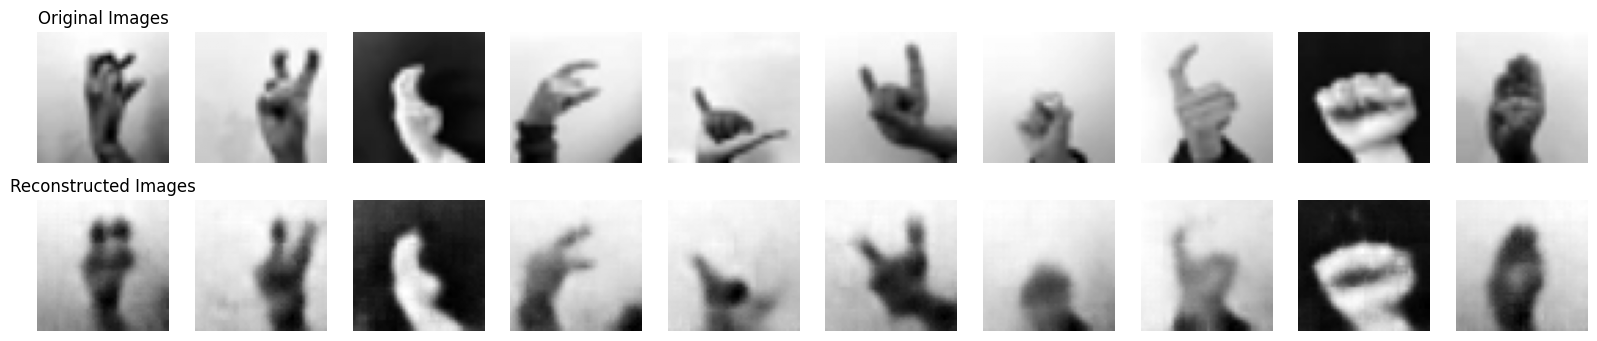

In [ ]:
show_original_vs_reconstructed(autoencoder, val_loader, device, 10)